In [1]:
import numpy as np

from dataloader import Mri3DDataLoader
from simple_model import Simple3DModel
from cnn_modelling.utils import SaveBestModelLoss
from cnn_modelling.model import MRINet
import numpy as np

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchmetrics.classification import BinaryHingeLoss

from tqdm import tqdm

In [2]:
PREPROCESSED_SCANS_DIRECTORY = r"/home/dpolak/Downloads/IXI_output/"
IXI_DEMOGRAPHIC_DATA = r"/home/dpolak/Downloads/IXI.xls"
num_epochs = 50
batch_size = 4

In [3]:
df_main = pd.read_excel(IXI_DEMOGRAPHIC_DATA)
df_main.dropna(inplace=True, subset=("IXI_ID", "SEX_ID (1=m, 2=f)", "AGE"))

## Splitting the data into train, test and validation

In [4]:
train_df, valid_df = train_test_split(df_main, test_size=0.2, random_state=2137, stratify=df_main["SEX_ID (1=m, 2=f)"])
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=2137)

In [5]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [6]:
train_dataloader = Mri3DDataLoader(train_df, PREPROCESSED_SCANS_DIRECTORY, batch_size=batch_size, augment=False)
valid_dataloader = Mri3DDataLoader(valid_df, PREPROCESSED_SCANS_DIRECTORY, batch_size=batch_size)
test_dataloader = Mri3DDataLoader(test_df, PREPROCESSED_SCANS_DIRECTORY, batch_size=batch_size)

Loaded 470 samples.
Loaded 59 samples.
Loaded 59 samples.


In [7]:
class_weights = (df_main["SEX_ID (1=m, 2=f)"].value_counts().to_numpy() / len(df_main)) ** -1
print(class_weights)

[1.79878049 2.2519084 ]


In [8]:
model = MRINet(pretrain=True, base_channels=16)
model = model.to("cuda")

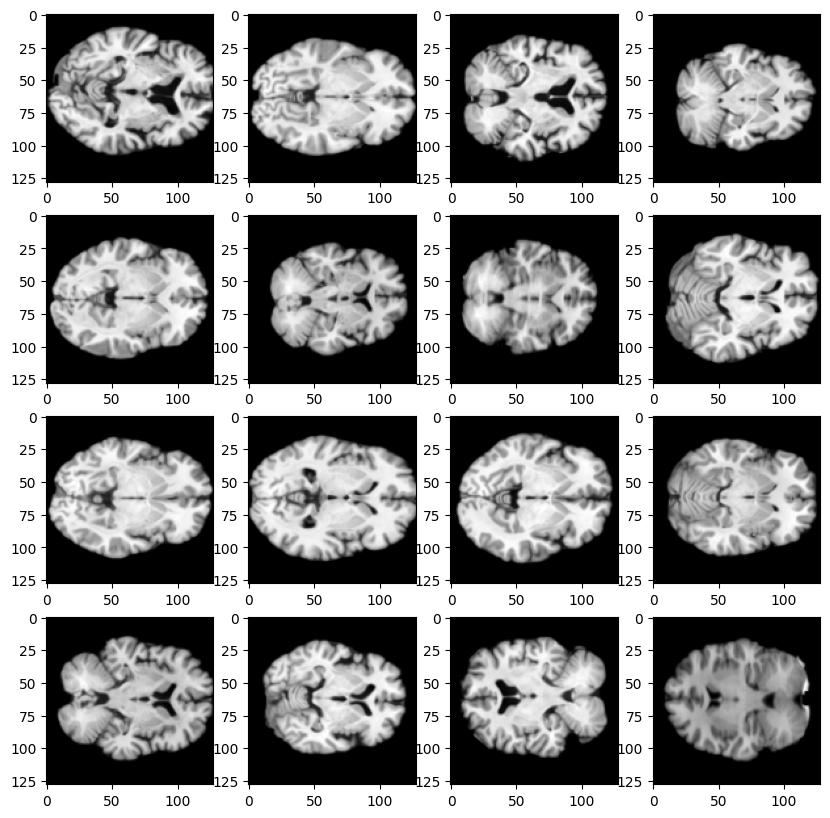

In [9]:
plt.figure(figsize=(10,10))
for i in range(16):
    image, (_, __) = train_dataloader[i]
    image = image.cpu().numpy()
    plt.subplot(4, 4, i+1)
    plt.imshow(image[0, 0, :, :, 50], cmap="gray")

In [10]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(x, y)) + 1e-6
        return loss

## Training the model

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion_ce = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
criterion_mse = torch.nn.L1Loss()
save_best = SaveBestModelLoss(save_path="models/pretrained")
history = {
    "train_loss": [],
    "val_loss": [],
}

for epoch in range(num_epochs):
    train_mse, train_ce, val_ce, val_mse, running_loss, val_running_loss = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    prbar = tqdm(train_dataloader, leave=True)
    model.train()
    step = 1
    results, ground_truths = [], []
    for batch in prbar:
        inputs, (gt_age, gt_sex) = batch
        optimizer.zero_grad()
        output_age, output_sex = model(inputs)
        mse = criterion_mse(output_age.squeeze().to("cpu"), gt_age)
        ce = criterion_ce(output_sex.squeeze().to("cpu"), gt_sex) * 10
        loss = mse + ce
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_mse += mse.item()
        train_ce += ce.item()
        
        probabilities = torch.argmax(torch.softmax(output_sex, dim=1), dim=1)
        results.extend(probabilities.to("cpu").detach().flatten().numpy())
        ground_truths.extend(torch.argmax(gt_sex, dim=1))
        
        accuracy = accuracy_score(ground_truths, results)
        balanced_accuracy = balanced_accuracy_score(ground_truths, results, adjusted=False)
        
        prbar.set_description(
            f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
            f"Train CE: {round(train_ce / (step * batch_size), 3)}, "
            f"Train MSE: {round(train_mse / (step * batch_size), 3)}, "
            f"Train Accuracy: {round(accuracy, 3)}, "
            f"Train Balanced Accuracy: {round(balanced_accuracy, 3)},"
            f"Running Loss: {round(running_loss / step, 3)}"
        )
        
        step += 1
        history["train_loss"].append(running_loss / step)
    model.eval()

    with torch.no_grad():
        step = 1
        results, ground_truths = [], []
        prbar = tqdm(valid_dataloader, leave=True)
        for batch in prbar:
            inputs, (gt_age, gt_sex) = batch
            output_age, output_sex = model(inputs)
            mse = criterion_mse(output_age.squeeze().to("cpu"), gt_age) 
            ce = criterion_ce(torch.sigmoid(output_sex).squeeze().to("cpu"), gt_sex) * 10
            probabilities = torch.argmax(torch.softmax(output_sex, dim=1), dim=1)
            
            results.extend(probabilities.to("cpu").detach().flatten().numpy())
            ground_truths.extend(torch.argmax(gt_sex, dim=1))
            
            accuracy = accuracy_score(ground_truths, results)
            balanced_accuracy = balanced_accuracy_score(ground_truths, results, adjusted=False)
            
            val_mse += mse.item()
            val_ce += ce.item()
            loss = ce + mse
            val_running_loss += loss.item()
            
            prbar.set_description(
                f"Epoch: {epoch}, Step loss: {round(loss.item(), 3)}, "
                f"Valid CE: {round(val_ce / (step * batch_size), 3)}, "
                f"Valid MSE: {round(val_mse / (step * batch_size), 3)}, "
                f"Validation Accuracy: {round(accuracy, 3)}, "
                f"Validation Balanced Accuracy: {round(balanced_accuracy, 3)},"
                f"Running Loss: {round(val_running_loss / step, 3)}"
            )
            
            step += 1
        history["val_loss"].append(val_running_loss / step)
    save_best(val_running_loss / step, epoch, model)

Epoch: 0, Step loss: 29.512, Train CE: 4.584, Train MSE: 5.045, Train Accuracy: 0.626, Train Balanced Accuracy: 0.615,Running Loss: 38.516: 100%|██████████| 117/117 [00:33<00:00,  3.51it/s] 
Epoch: 0, Step loss: 27.591, Valid CE: 3.15, Valid MSE: 2.909, Validation Accuracy: 0.661, Validation Balanced Accuracy: 0.651,Running Loss: 24.237: 100%|██████████| 14/14 [00:03<00:00,  4.19it/s] 



Best validation loss: 22.6209844456069

Saving best model for epoch: 1


Epoch: 1, Step loss: 27.965, Train CE: 3.455, Train MSE: 2.723, Train Accuracy: 0.694, Train Balanced Accuracy: 0.686,Running Loss: 24.713: 100%|██████████| 117/117 [00:31<00:00,  3.68it/s]
Epoch: 1, Step loss: 25.954, Valid CE: 3.054, Valid MSE: 2.309, Validation Accuracy: 0.732, Validation Balanced Accuracy: 0.727,Running Loss: 21.45: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s] 



Best validation loss: 20.020390798807547

Saving best model for epoch: 2


Epoch: 2, Step loss: 17.554, Train CE: 2.942, Train MSE: 2.528, Train Accuracy: 0.722, Train Balanced Accuracy: 0.712,Running Loss: 21.879: 100%|██████████| 117/117 [00:31<00:00,  3.73it/s]
Epoch: 2, Step loss: 29.26, Valid CE: 2.913, Valid MSE: 3.079, Validation Accuracy: 0.75, Validation Balanced Accuracy: 0.745,Running Loss: 23.967: 100%|██████████| 14/14 [00:03<00:00,  4.15it/s] 
Epoch: 3, Step loss: 19.887, Train CE: 3.02, Train MSE: 2.537, Train Accuracy: 0.746, Train Balanced Accuracy: 0.738,Running Loss: 22.228: 100%|██████████| 117/117 [00:31<00:00,  3.72it/s] 
Epoch: 3, Step loss: 30.143, Valid CE: 2.97, Valid MSE: 5.96, Validation Accuracy: 0.714, Validation Balanced Accuracy: 0.705,Running Loss: 35.721: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s]  
Epoch: 4, Step loss: 28.749, Train CE: 2.242, Train MSE: 2.665, Train Accuracy: 0.795, Train Balanced Accuracy: 0.784,Running Loss: 19.628:  24%|██▍       | 28/117 [00:07<00:24,  3.62it/s]

KeyboardInterrupt



In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
test_results_age = []
test_ground_truths_age = []
test_results_sex = []
test_ground_truths_sex = []
for test_batch in test_dataloader:
    output_age, output_sex = model.forward(test_batch[0])
    test_results_age.extend(output_age.squeeze().to("cpu").detach().numpy())
    test_ground_truths_age.extend(test_batch[1][0].squeeze().to("cpu").detach().numpy())
    test_results_sex.extend(torch.argmax(torch.softmax(output_sex, dim=1), dim=1).to("cpu").detach().numpy())
    test_ground_truths_sex.extend(torch.argmax(test_batch[1][1], dim=1))
    
test_accuracy = accuracy_score(test_ground_truths_sex, test_results_sex, normalize=True)
test_balanced_accuracy = balanced_accuracy_score(test_ground_truths_sex, test_results_sex,  adjusted=False)
test_mse = mean_squared_error(test_ground_truths_age, test_results_age)
test_mae = mean_absolute_error(test_ground_truths_age, test_results_age)
test_r2 = r2_score(test_ground_truths_age, test_results_age)
print(f"Test Accuracy: {round(test_accuracy, 3)}")
print(f"Test Balanced Accuracy: {round(test_balanced_accuracy, 3)}")
print(f"Test MSE: {round(test_mse, 3)}")
print(f"Test MAE: {round(test_mae, 3)}")
print(f"Test R2: {round(test_r2, 3)}")

Test Accuracy: 0.679
Test Balanced Accuracy: 0.714
Test MSE: 1117.0169677734375
Test MAE: 31.22100067138672
Test R2: -2.648


In [ ]:
np.concatenate((np.array(test_results_age).reshape(-1, 1), np.array(test_ground_truths_age).reshape(-1, 1)), axis=1)

In [ ]:
np.concatenate((np.array(test_results_sex).reshape(-1,1), np.array(test_ground_truths_sex).reshape(-1,1)), axis=1)